## NBA Home Court Advantage

### Part 3: Do Teams Have Different Amounts of Home Court Advantage?

This notebook looks at whether particular NBA teams have demonstrated significantly different amounts of home court advantage over time. This is challenging, since team quality varies significantly over time.

The punchline? There is only very weak statistical evidence that teams have persistent and measurable differences in home court advantage relative to the league average.

As with the [previous](http://nbviewer.jupyter.org/github/practicallypredictable/posts/blob/master/notebooks/nba_home_court-part1.ipynb) [notebooks](http://nbviewer.jupyter.org/github/practicallypredictable/posts/blob/master/notebooks/nba_home_court-part2.ipynb) in this series on NBA home court advantage, we will look at 24,797 match ups from the 1996-97 through 2016-17 regular seasons.

Let's look at the data.

In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.options.display.float_format = '{:.3f}'.format

In [2]:
from scipy import stats

In [3]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
import seaborn as sns
sns.set()
sns.set_context('notebook')
plt.style.use('ggplot')

In [4]:
from pathlib import Path

Let's load the data. See the previous notebooks for more information on how to obtain the data.

In [5]:
PROJECT_DIR = Path.cwd().parent / 'basketball' / 'nba'
DATA_DIR = PROJECT_DIR / 'data' / 'prepared'
DATA_DIR.mkdir(exist_ok=True, parents=True)

In [6]:
def load_nba_historical_matchups(input_dir):
    """Load pickle file of NBA matchups prepared for analytics."""
    PKLFILENAME = 'stats_nba_com-matchups-1996_97-2016_17.pkl'
    pklfile = input_dir.joinpath(PKLFILENAME)
    return pd.read_pickle(pklfile)

In [7]:
matchups = load_nba_historical_matchups(DATA_DIR)
matchups.shape

(26787, 41)

In [8]:
seasons = sorted(list(matchups['season'].unique()))
len(seasons)

21

In [9]:
def prepare_regular_season(matchups):
    df = matchups.copy()
    df = df[df['season_type'] == 'regular']
    return df

In [10]:
reg = prepare_regular_season(matchups)
reg.shape

(24797, 41)

In [11]:
teams = sorted(list(reg['team_curr_h'].unique()))
len(teams)

30

In [12]:
def load_win_loss_information():
    csvfile = DATA_DIR.joinpath('stats_nba_com-team_records-1996_97-2016_17.csv')
    df = pd.read_csv(csvfile)
    return df

In [13]:
wl = load_win_loss_information()
wl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 622 entries, 0 to 621
Data columns (total 14 columns):
season                 622 non-null object
team                   622 non-null object
games                  622 non-null int64
wins                   622 non-null int64
losses                 622 non-null int64
win_percentage         622 non-null float64
home_games             622 non-null int64
home_wins              622 non-null int64
home_losses            622 non-null int64
home_win_percentage    622 non-null float64
away_games             622 non-null int64
away_wins              622 non-null int64
away_losses            622 non-null int64
away_win_percentage    622 non-null float64
dtypes: float64(3), int64(9), object(2)
memory usage: 68.1+ KB


### Home Versus Away Win Percentage

Now that we have the data, we will do a simple analysis. We want to simply take the difference between home win percentage and away win percentage, grouped by season and team.

This is a simple way to think about isolating the impact of home court advantage. Weak teams should have relatively weak home and away records, and strong teams should have relatively strong home and away records. Taking the difference between the home and away win percentage should average out the differences between teams and focus on the impact of the home court.

The [NBA schedule](https://www.nbastuffer.com/analytics101/how-the-nba-schedule-is-made/) isn't perfectly balanced, in the sense that the average quality of home opponents may differ randomly from the quality of road opponents. But, there's no reason I'm aware of to think that there is a systematic bias in how the home versus away games are scheduled from season to season. We will analyze the schedule and home versus away records by conference and division in a future post, to see if that has any impact on a team's home court advantage.

Although teams can vary significantly intra-season due to trades and injuries, the regular season is a reasonable time unit for analyzing team performance.

In [14]:
hca = wl[['season', 'team', 'home_win_percentage', 'away_win_percentage']].copy()
hca['home_away_diff'] = hca['home_win_percentage'] - hca['away_win_percentage']
hca.describe()

,home_win_percentage,away_win_percentage,home_away_diff
count,622.000,622.000,622.000
mean,0.598,0.402,0.197
std,0.170,0.159,0.107
min,0.121,0.040,-0.121
25%,0.488,0.293,0.122
50%,0.610,0.415,0.195
75%,0.732,0.512,0.268
max,0.976,0.829,0.585


There are 622 distinct team/season pairs. Let's group these data by team and aggregate the statistics over the 21 complete seasons.

These are the 5 teams with the highest observed average home court advantage, measured by home versus away win percentage differential.

In [15]:
hca.groupby('team')['home_away_diff'].describe().sort_values('mean', ascending=False).head()

,count,mean,std,min,25%,50%,75%,max
team,,,,,,,,
DEN,21.000,0.258,0.138,0.024,0.171,0.293,0.366,0.463
UTA,21.000,0.245,0.125,0.073,0.171,0.244,0.293,0.488
IND,21.000,0.239,0.101,0.073,0.146,0.220,0.341,0.390
ATL,21.000,0.231,0.110,0.040,0.146,0.244,0.317,0.415
CLE,21.000,0.227,0.083,0.030,0.195,0.244,0.268,0.390


And these 5 teams have the lowest observed average home court advantage.

In [16]:
hca.groupby('team')['home_away_diff'].describe().sort_values('mean', ascending=False).tail()

,count,mean,std,min,25%,50%,75%,max
team,,,,,,,,
MIA,21.000,0.172,0.121,-0.073,0.073,0.195,0.244,0.390
HOU,21.000,0.172,0.112,-0.098,0.098,0.171,0.280,0.317
BOS,21.000,0.164,0.114,-0.049,0.098,0.171,0.220,0.415
TOR,21.000,0.160,0.073,0.049,0.098,0.146,0.200,0.317
PHI,21.000,0.132,0.095,-0.073,0.049,0.146,0.195,0.293


There are some familiar names in these lists. Denver and Utah often show up in [articles about home court advantage](http://www.espn.com/nba/insider/story/_/id/9014283/nba-analyzing-real-home-court-advantage-utah-jazz-denver-nuggets). Some [people attribute the supposed extra home court advantage to the altitude and the time zone](https://www.cbssports.com/nba/news/nba-trying-to-weaken-nuggets-home-court-advantage/) of Denver and Salt Lake City. There's even [an article studying the potential effect of altitude on free throw shooting percentage](https://harvardsportsanalysis.wordpress.com/2011/05/18/does-altitude-affect-free-throw-percentage/). And, lastly, here's [an article that attempts to rank all 30 NBA teams by home court advantage](https://www.foxsports.com/nba/gallery/ranking-every-nba-teams-home-court-advantage-112816), without any data to support the rankings.

In the words of the great American statistician [W. Edwards Deming](https://en.wikipedia.org/wiki/W._Edwards_Deming), "In God we trust; all others must bring data."

Needless to say, I'm skeptical.

### Survey Says...

Here's a [box plot](https://en.wikipedia.org/wiki/Box_plot) of the home versus away win percentages for all 30 NBA teams. The dashed horizontal line shows the overall median home versus away win percentage differential of roughly 20%.

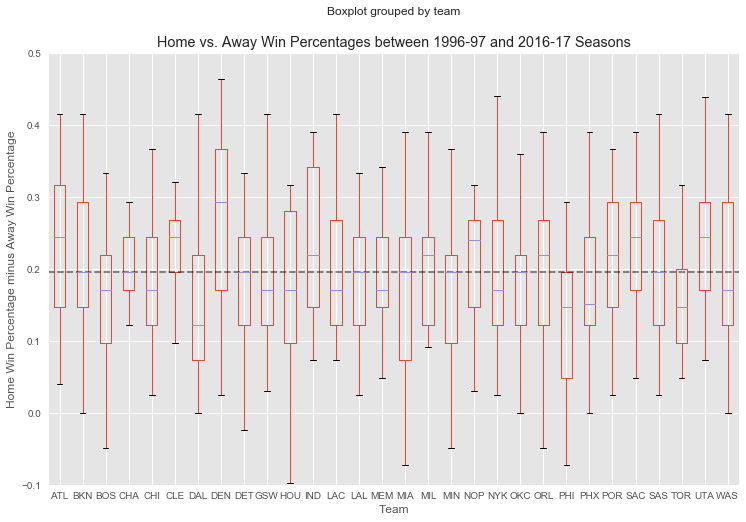

In [17]:
fig, ax = plt.subplots(figsize=(12,8))
ax = hca.boxplot('home_away_diff', by='team', ax=ax)
ax.set_title('Home vs. Away Win Percentages between 1996-97 and 2016-17 Seasons')
ax.set_ylim(-0.1, 0.5)
ax.set_ylabel('Home Win Percentage minus Away Win Percentage')
ax.set_xlabel('Team')
ax.axhline(hca['home_away_diff'].median(), linestyle='--', alpha=0.5, color='black')
plt.show()

In [18]:
hca['home_away_diff'].median()

0.19512200000000002

The main thing to notice about this plot is the significant variability in the data. Denver's away win percentage has varied between 2% less than its home win percentage to as much as 46% less. Of course, a large win percentage differential could occur because a team has an awful road record or because it has an outstanding home record. Similarly, a small win percentage differential could occur because a team is outstanding on the road or is relatively weak at home.

The rectangles on the plot display the [interquartile range](https://en.wikipedia.org/wiki/Interquartile_range) for each team. The interquartial range is the difference between the 75% quantile and the 25% quantile. Approximately half of the observations for each team occur in each of the relevant rectangles.

The grey lines within each rectangle represent the [median](https://en.wikipedia.org/wiki/Median) for each team. Approximately half of the win percentage differentials are above this line, and half are below this line.

(For the purists, the reason I say "approximately" in the preceding sentences is due to the fact that some fine-tuning may be required to break ties, depending upon the number of data points. See the links above for details on the calculation of median and interquartile range if you're interested.)

All of the interquartile ranges intersect the line representing the overall median. If a team had a significantly different home court advantage (or disdvantage), you would expect to see that more clearly in the plot.

This plot doesn't attempt to separate out the reasons why the home versus away win percentage varies so much. That will have to wait for another day. But, if the question being asked is does a team have a consistent and measurably different home court advantage, this plot certainly doesn't support a yes answer to that question.

### Analysis of Variance

There are more formal statistical tests of whether several groups have the same mean. An example of this is [one-way analysis of variance](https://en.wikipedia.org/wiki/One-way_analysis_of_variance), or ANOVA. The details don't matter much, but to illustrate the method in Python, here is a one-way ANOVA testing whether all the teams have the same mean home versus away win percentage differential.

In Python, it's easy to use the `scipy` statistics package to perform this test.

In [19]:
data = [hca.loc[hca['team'] == team, 'home_away_diff'] for team in teams]

In [20]:
f_val, p_val = stats.f_oneway(*data)
p_val

0.090958554085467463

In one-way ANOVA, the [null hypothesis](http://www.statisticshowto.com/probability-and-statistics/null-hypothesis/) is that all the means are the same. For the NBA data, the resulting [_p-value_](http://www.dummies.com/education/math/statistics/what-a-p-value-tells-you-about-statistical-data/) of 9.1% is only very weak evidence against the null hypothesis that all the home court advantages are the same.

The statistical test tells the same story as the plot. The data are too noisy to support a strong conclusion.

### Quantifying Differences in Home Court Advantage

Even though we've seen that the data don't really support the argument that different teams have consistently different amounts of home court advantage, let's take the analysis just a little bit further.

Suppose for a moment that teams really did have different home court advantages. How would you use that information?

Under the NBA schedule, every team plays the same number of home and away games every season. So, with a little bit of algebra, you can show that the overall win percentage is the average of the home win percentage and the away win percentage.

Also, remember that the way we are estimating home court advantage here is home win percentage minus away win percentage. The average team has roughly a 20% gap between home and away win percentages. But, as we've seen in prior posts, the gap between the home win percentage and the overall win percentage is around 10%. That is, half of 20%.

So, if a particular team had a significantly better home court advantage than the league average, the predicted impact on the overall season win percentage would only be half of the difference between that teams's home court advantage, and the league average home court advantage.

Let's estimate the predicted impact on overall win percentage, assuming that each team really did have different home court advantages.

We'll estimate the home court advantage using the [_interquartile mean_](https://en.wikipedia.org/wiki/Interquartile_mean), which is the just the average of the 25% and 75% quartiles. It's not the same as the median. You can visualize the interquartile mean as being the centers of the rectangles in the box plot above.

Here are the 5 best and 5 worst NBA team home court advantages, estimated by the historical interquartile mean over the past 21 completed NBA seasons.

In [21]:
def iq_mean(x):
    return (x.quantile(0.75) + x.quantile(0.25))/2

In [22]:
y = hca.groupby('team')['home_away_diff'].agg(iq_mean).sort_values(ascending=False)
y.head()

team
DEN   0.268
IND   0.244
ATL   0.232
CLE   0.232
UTA   0.232
Name: home_away_diff, dtype: float64

In [23]:
y.tail()

team
MIA   0.159
MIN   0.159
TOR   0.149
DAL   0.146
PHI   0.122
Name: home_away_diff, dtype: float64

Now, we can just subtract out the league interquartile mean and divide by 2, to look at the impact on each team's estimated overall win percentage.

In [24]:
m = sum(y)/len(y)
m

0.19417887500000003

In [25]:
home_edge = (y - m)/2
home_edge

team
DEN    0.037
IND    0.025
ATL    0.019
CLE    0.019
UTA    0.019
SAC    0.019
POR    0.013
BKN    0.013
CHA    0.007
WAS    0.007
NOP    0.007
NYK    0.000
SAS    0.000
LAC    0.000
MEM    0.000
ORL    0.000
HOU   -0.003
MIL   -0.006
GSW   -0.006
DET   -0.006
PHX   -0.006
LAL   -0.006
CHI   -0.006
OKC   -0.012
BOS   -0.018
MIA   -0.018
MIN   -0.018
TOR   -0.023
DAL   -0.024
PHI   -0.036
Name: home_away_diff, dtype: float64

Notice that by this measure, Indiana, Atlanta and Cleveland rank better than Utah, despite the claim that Salt Lake City's altitude helps the Jazz. The Jazz just don't stand out as much using the interquartile mean. This suggests some historical [outliers](https://en.wikipedia.org/wiki/Outlier) may be influencing the common perception that the Jazz enjoy a special degree of home court advantage.

What's also interesting is the teams at the bottom. People usually don't think of OKC, Boston or Toronto as suffering from significantly below-average home court advantage.

If Denver really did have such a large relative home court advantage compared to the league average, it would be expected to pick up roughly an extra 3 games per season on average. It's hard to detect that effect in the noisy year-to-year variation of the team's record.

The general take-away is: treat claims of persistent home court advantage in the sports media with skepticism.